### Project  Movie Prophet
#### A project to create a predictive model to forecast a movie's performance on the Box Office
#### Team Members - Nelson Dsouza, Maria George, Saurabh Seth

In [78]:
# Load libraries and instatiate DB connection

%matplotlib inline
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='mprophet',
                             db='movies')

In [2]:
# Pull table from database

cur = connection.cursor()

cur.execute("SELECT * FROM bom_summary")
bom_summary_sql = []
for row in cur: bom_summary_sql.append(list(row))
    
cur.execute("SELECT * FROM bom_players")
bom_players_sql = []
for row in cur: bom_players_sql.append(list(row))

cur.close()
connection.close()

In [3]:
# Store table information in DataFrame

bom_summary_columns = ['link', 'name', 'budget', 'rev_tot', 'rev_lif', 'rel_dt', 'runtime',
                       'distributor', 'genre', 'rating', 'awards']
bom_summary = pd.DataFrame(bom_summary_sql, columns=bom_summary_columns)

bom_players_columns = ['link', 'name', 'actor', 'assoc_producer', 'cinematographer', 'composer', 'director',
                       'exec_producer', 'line_producer', 'players', 'producer', 'writer']
bom_players = pd.DataFrame(bom_players_sql, columns=bom_players_columns)

In [4]:
print(len(bom_summary))
bom_summary.head(1)

16828


,link,name,budget,rev_tot,rev_lif,rel_dt,runtime,distributor,genre,rating,awards
0,http://www.boxofficemojo.com/movies/?id=horrorifc.htm,#Horror,N/A,,,20-Nov-15,1 hrs. 30 min.,IFC,Horror,Unknown,No Academy Awards Information\r


In [5]:
print(len(bom_players))
bom_players.head(1)

16828


,link,name,actor,assoc_producer,cinematographer,composer,director,exec_producer,line_producer,players,producer,writer
0,http://www.boxofficemojo.com/movies/?id=horrorifc.htm,#Horror,"""['Balthazar Getty', 'Timothy Hutton', 'Natasha Lyonne', 'Taryn Manning', 'Chloe Sevigny']""",,,,,,,,,\r


In [6]:
# Cleaning actor names and storing in list

len(bom_players[bom_players['players'] == 'No Player Information'])

# Cleat the actor column
bom_players['actor_clean'] = bom_players['actor'].str.replace('[','')
bom_players['actor_clean'] = bom_players['actor_clean'].str.replace(']','')
bom_players['actor_clean'] = bom_players['actor_clean'].str.replace('"','')
bom_players['actor_clean'] = bom_players['actor_clean'].str.replace("'",'')
bom_players['actor_clean'] = bom_players['actor_clean'].str.replace(", ",',')
bom_players['actor_clean'] = bom_players['actor_clean'].str.replace("*",',')

bom_players['actor_clean'] = bom_players['actor_clean'].apply(lambda x: x.split(','))

In [8]:
# Getting unique actors

actor_unq = list(bom_players['actor_clean'])
actor_unq = list(set(sum(actor_unq, [])))
actor_unq = [e for e in actor_unq if e not in ('', ' ')]
actor_unq = dict((ky,0) for ky in actor_unq)
len(actor_unq)

5054

In [60]:
# Calclulate the Profit/Loss ratio for each movie which has data for budget and domestic total gross 

bs = bom_summary[(bom_summary['budget'] != 'N/A') & (bom_summary['rev_tot'] != '')].copy()
bs['budget'] = bs['budget'].str.replace('$','')
bs['budget'] = bs['budget'].str.replace('"','')
bs['budget'] = bs['budget'].str.replace(',','')

bs.loc[bs.budget.str.contains('million'),'budget'] = bs.loc[
    bs.budget.str.contains('million'), 'budget'].apply(lambda x: float(x.replace('million', ''))*1000000)

bs['rev_tot'] = bs['rev_tot'].astype(float)
bs['budget'] = bs['budget'].astype(float)
bs['pl'] = (bs['rev_tot'] - bs['budget']) / bs['budget']

bs.head(2)

,link,name,budget,rev_tot,rev_lif,rel_dt,runtime,distributor,genre,rating,awards,pl
10,http://www.boxofficemojo.com/movies/?id=500daysofsummer.htm,(500) Days of Summer,7500000,32391374,,17-Jul-09,1 hrs. 35 min.,Fox Searchlight,Romance,PG-13,No Academy Awards Information\r,3.318850
24,http://www.boxofficemojo.com/movies/?id=10thingsihateaboutyou.htm,10 Things I Hate About You,30000000,38178166,,31-Mar-99,1 hrs. 37 min.,Buena Vista,Romantic Comedy,PG-13,No Academy Awards Information\r,0.272606


In [61]:
# Merge player data with Profit/Loss data

mov_pl = pd.merge(bs[['name', 'link', 'pl']], bom_players[['link', 'actor_clean']], on = 'link', how = 'inner')
print(len(mov_pl))
mov_pl.head(1)

3066


,name,link,pl,actor_clean
0,(500) Days of Summer,http://www.boxofficemojo.com/movies/?id=500daysofsummer.htm,3.31885,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly, ]"


In [62]:
# For each actor, assign score which is the profit/loss of their movie

mov_actors = list(mov_pl['actor_clean'])
mov_actors = [[actor for actor in mov if actor not in ('', ' ')] for mov in mov_actors]

ind = 0
for actors in mov_actors:
    for actor in actors:
        actor_unq[actor] += float(mov_pl.loc[ind, ['pl']])
        if actor == 'I': print(mov_pl.loc[ind, ['name','actor_clean', 'pl']])
    ind+=1

In [68]:
actor_unq['Will Smith']

47.923627598129336

In [72]:
# Pull the actor feature into dataframe

f_actor = pd.Series(actor_unq, name='score').to_frame()
f_actor = f_actor.sort_values(by='score', ascending=False)
f_actor.reset_index(inplace=True)
f_actor.columns=['Actors', 'score']
f_actor.head(5)

,Actors,score
0,Alex Kendrick,368.914109
1,Jamie Lee Curtis,317.599081
2,Kevin Smith,246.685632
3,Jason Mewes,241.835792
4,Jon Heder,228.868031


In [88]:
# Calculating statistics

f_actor.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,5054,6.997109,18.670764,-1.944639,0,0,4.568833,368.914109


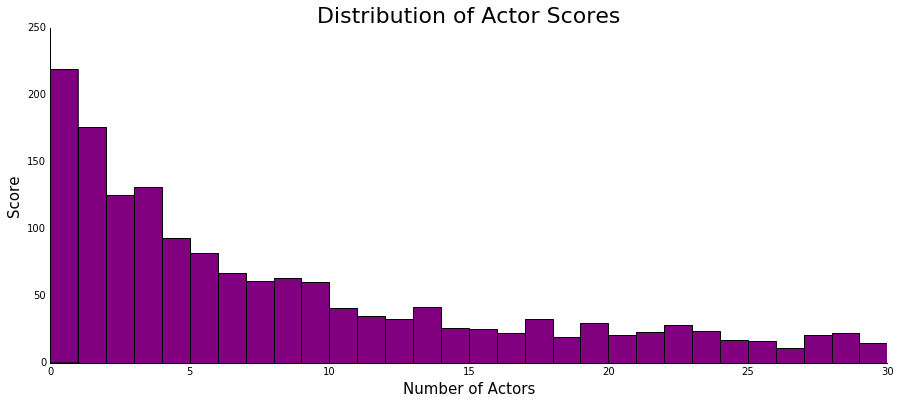

In [83]:
# Analyzing distribution

plt.figure(1, figsize = (15,6))
plt.hist(list(f_actor[f_actor['score'] != 0]['score']), range=[0,30], bins=(30), facecolor='purple')
plt.title("Distribution of Actor Scores", fontsize = 22)
plt.ylabel("Score", fontsize = 15)
plt.xlabel("Number of Actors", fontsize=15)

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

plt.savefig('Actor_Distribution.png')